##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [1]:
!pip install -q tensorflow-gpu==2.1.0

Install TensorFlow Quantum:

In [31]:
!pip install tensorflow-quantum

  Using cached https://files.pythonhosted.org/packages/e2/60/3c73e8c4b68efdd84927e3a2975c52fbf9af50305c3dbecbf0557b8f7b73/tensorflow_quantum-0.3.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/21/21/f4105795ca7f35c541d82c5b06be684dd2f5cb4f508fb487cd7aea4de776/sympy-1.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b8/cf/d95635b4b0de2227956077687277426299883ccdb9e6418fa6e599893ea3/cirq-0.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/17/5d/1b9d6d3c7995fff473f35861d674e0113a5f0bd5a72fe0199c3f254665c7/freezegun-0.3.15-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/0e/3f026d0645d699e7320b59952146d56ad7c374e9cd72cd16e7c74e657a0f/typing_extensions-3.7.4.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/fb/29de8d08967f0cce1bb10b39846d836b0f3bf6776ddc36aed7c73498ca7e/protobuf-3.8.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached http

    Uninstalling networkx-2.2:
      Successfully uninstalled networkx-2.2
  Found existing installation: google-auth 1.11.0
    Uninstalling google-auth-1.11.0:
      Successfully uninstalled google-auth-1.11.0
  Found existing installation: grpcio 1.17.1
    Uninstalling grpcio-1.17.1:
      Successfully uninstalled grpcio-1.17.1


In [1]:
!pip install --upgrade protobuf

    100% |████████████████████████████████| 1.3MB 17.6MB/s ta 0:00:01
cirq 0.8.0 has requirement protobuf==3.8.0, but you'll have protobuf 3.12.2 which is incompatible.
  Found existing installation: protobuf 3.8.0
    Uninstalling protobuf-3.8.0:
      Successfully uninstalled protobuf-3.8.0


Now import TensorFlow and the module dependencies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

In [6]:
!pip install matplotlib seaborn

     |████████████████████████████████| 215 kB 5.9 MB/s eta 0:00:01


In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow_quantum as tfq



import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Circ circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [12]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [13]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


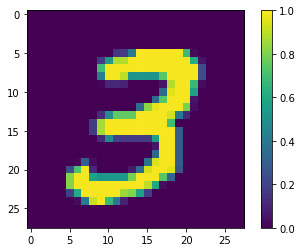

In [14]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [23]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


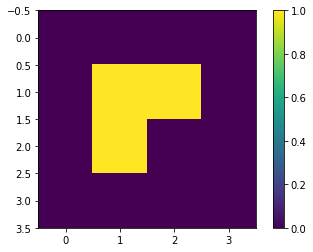

In [24]:
print(y_train[0])

plt.imshow((x_train_small[1800,:,:,0] > 0.25) , vmin=0, vmax=1)
plt.colorbar()

In [25]:
def convert_to_angle(b_st):
    if b_st[0] == 1:
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == 1 and b_st[2] == 1:
        varphi = np.pi / 4

    if b_st[1] == 1 and b_st[2] == 0:
        varphi = 3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 0:
        varphi = -3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 1:
        varphi = -np.pi / 4
            
    return [theta, varphi]

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [26]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [27]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

### 1.3 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [28]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.int32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.int32)

In [29]:
# x_train_bin, y_train_nocon = remove_contradicting(x_train_bin, y_train)
_ = remove_contradicting(x_train_bin, y_train)

Number of unique images: 193
Number of 3s:  158
Number of 6s:  160
Number of contradictory images:  125

Initial number of examples:  11520
Remaining non-contradictory examples:  91


In [30]:
x_train_bin.shape, y_train_nocon.shape

((11520, 4, 4, 1), (11520,))

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

# Flatten Encoding
Encode pixel by flatten

In [14]:
# Augmented Encoding

data_train = []
data_test = []

num_bit = 24
num_qubit = num_bit // 3

def encode31(data):
    var_list = []
    for i in range(1,5):
        var_list += convert_to_angle(data[i,0:3])
        var_list += convert_to_angle(data[i,3:6])

    return var_list


for row in x_train_bin:
    data_train.append(encode31(row))
    
for row in x_test_bin:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [15]:
data_train.shape

(12049, 16)

In [33]:
x_train_flatten

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [34]:
x_train_flatten = x_train_bin.reshape((-1,16))
x_test_flatten = x_test_bin.reshape((-1,16))

data_train = []
data_test = []

num_bit = 16
num_qubit = num_bit // 3

def encode31(data):
    
    data = data.reshape(-1).tolist()
    data += [0] * ((3-len(data)) % 3)


    var_list = []
    for i in range(0, len(data), 3):
        var_list += convert_to_angle(data[i:i+3])

    return var_list

for row in x_train_flatten:
    data_train.append(encode31(row))
    
for row in x_test_flatten:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [35]:
data_train.shape

(11520, 12)

In [39]:
data_train = []
data_test = []
    
# Count required bit
num_bit = 36
num_qubit = num_bit // 3

def encode31(data):
    
    var_list = []
    for i in range(2):
        for j in range(2):
            encode_dat = data[i:i+3, j:j+3].reshape([-1, 3])
            for dat in encode_dat:
                var_list += convert_to_angle(dat)

    return var_list


# num_bit = 24
# num_qubit = num_bit // 3
# def encode31(data):

#     var_list = []
#     for i in range(4):
#         for j in range(2):
#             encode_dat = data[i, j:j+3].reshape(-1)
#             var_list += convert_to_angle(encode_dat)

#     return var_list
    
# Encode train

for row in x_train_bin:
    data_train.append(encode31(row))
    
for row in x_test_bin:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [15]:
data_train = []
data_test = []
    
# Count required bit
num_bit = 48
num_qubit = num_bit // 3

def encode31(data):
    data = np.squeeze(data)
    
    var_list = []
    for i in range(4):
        for j in range(2):
            encode_dat = data[i, j:j+3].reshape(-1)
#             convert_to_angle(encode_dat)
#             print(encode_dat.shape)
            var_list += convert_to_angle(encode_dat)
            
    dataT = data.T
    for i in range(4):
        for j in range(2):
            encode_dat = dataT[i, j:j+3].reshape(-1)
            var_list += convert_to_angle(encode_dat)

    return var_list
    
# Encode train

for row in x_train_bin:
    data_train.append(encode31(row))
    
for row in x_test_bin:
    data_test.append(encode31(row))

data_train = np.array(data_train)
data_test = np.array(data_test)

In [16]:
data_train.shape

(11520, 32)

In [16]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [20]:
# def create_model_circuit(qubits):
#     """Create sequence of alternating convolution and pooling operators 
#     which gradually shrink over time."""
#     model_circuit = cirq.Circuit()
#     symbols = sympy.symbols('qconv0:84')
#     # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
#     # scans incoming circuits and replaces these with TensorFlow variables.
#     model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
#     model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
#                                           symbols[15:21])
#     model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
#     model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
#                                           symbols[36:42])
#     model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
#     model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
#                                           symbols[57:63])
#     model_circuit += quantum_conv_circuit(qubits[14:15], symbols[63:78])
#     model_circuit += quantum_pool_circuit([qubits[14]], [qubits[15]],
#                                           symbols[78:84])
#     return model_circuit

def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
#     symbols = sympy.symbols('qconv0:84')
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[6:7], qubits[7:8],
                                          symbols[57:63])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [21]:
qcnn_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_4 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc_2 (PQC)                  (None, 1)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


Convert these `Cirq` circuits to tensors for `tfq`:

In [41]:
num_qubit = 6

In [42]:
def convert_to_circuit(data):
    """Encode truncated classical image into quantum datapoint."""
    values = data
    qubits = cirq.GridQubit.rect(num_qubit,1)
    circuit = cirq.Circuit()
    for i in range(len(data) // 2):
        circuit.append(cirq.rx(data[2*i])(qubits[i]))
        circuit.append(cirq.ry(data[2*i+1])(qubits[i]))
#     for i, value in enumerate(values):
#         if value:
#             circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in data_train]
x_test_circ = [convert_to_circuit(x) for x in data_test]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


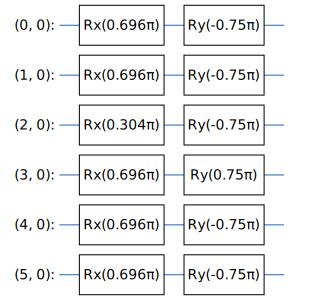

In [43]:
SVGCircuit(x_train_circ[1])

In [24]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [25]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [26]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [27]:
print(qcnn_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_4 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc_2 (PQC)                  (None, 1)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [28]:
EPOCHS = 10
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
# NUM_EXAMPLES = 1000

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [31]:
qcnn_model.compile(loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc_sub,
                         y=y_train_hinge_sub,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(x_test_tfcirc, y_test_hinge))

Train on 12049 samples, validate on 1968 samples
Epoch 1/25
12049/12049 [==============================] - 1364s 113ms/sample - loss: 0.8785 - hinge_accuracy: 0.6629 - val_loss: 0.8859 - val_hinge_accuracy: 0.6220
Epoch 2/25
12049/12049 [==============================] - 1358s 113ms/sample - loss: 0.7977 - hinge_accuracy: 0.6629 - val_loss: 0.8207 - val_hinge_accuracy: 0.6220
Epoch 3/25
12049/12049 [==============================] - 1356s 113ms/sample - loss: 0.7602 - hinge_accuracy: 0.6629 - val_loss: 0.8209 - val_hinge_accuracy: 0.6220
Epoch 4/25
 6016/12049 [=============>................] - ETA: 11:09 - loss: 0.7564 - hinge_accuracy: 0.6657

KeyboardInterrupt: 

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [44]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            print(cirq.unitary(gate(qubit, self.readout)**0.98))

Build an example circuit layer to see how it looks:

[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j 

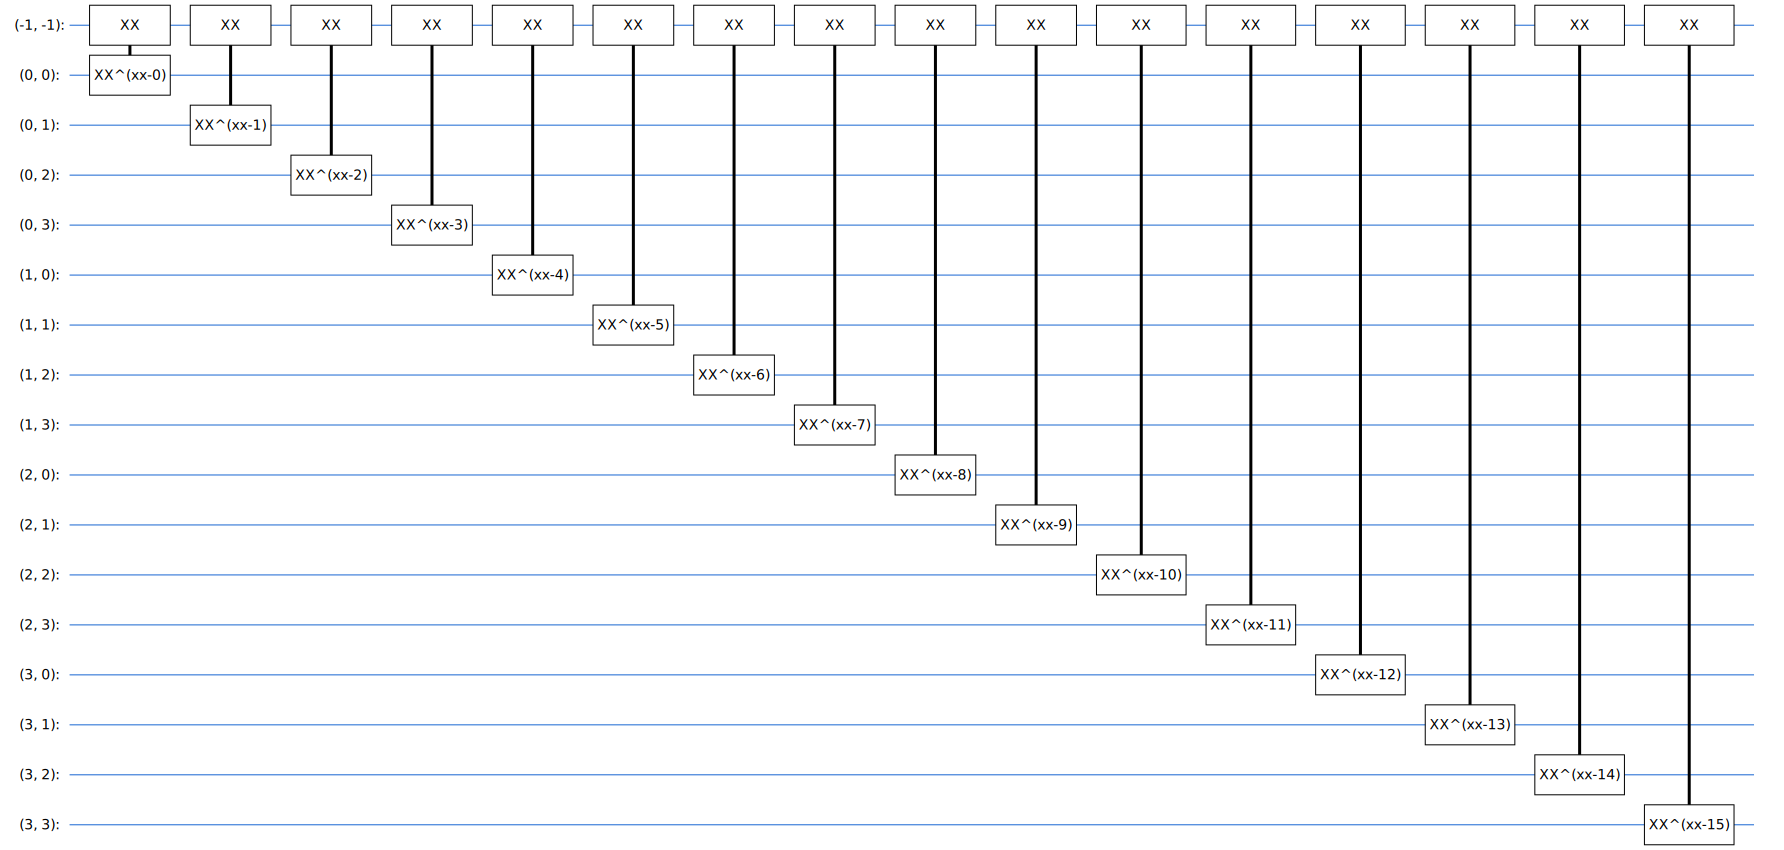

In [45]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,4),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [16]:
num_qubit = 10

In [49]:
LAYER = 2
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(num_qubit,1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    for i in range(LAYER):
        builder.add_layer(circuit, cirq.XX, f"xx{i}")
        builder.add_layer(circuit, cirq.ZZ, f"zz{i}")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [50]:
model_circuit, model_readout = create_quantum_model()

[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j         9.86635786e-04+0.03139526j
  9.99013364e-01-0.03139526j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.99013364e-01-0.03139526j
  9.86635786e-04+0.03139526j 0.00000000e+00+0.j        ]
 [9.99013364e-01-0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.86635786e-04+0.03139526j]]
[[9.86635786e-04+0.03139526j 0.00000000e+00+0.j
  0.00000000e+00+0.j         9.99013364e-01-0.03139526j]
 [0.00000000e+00+0.j 

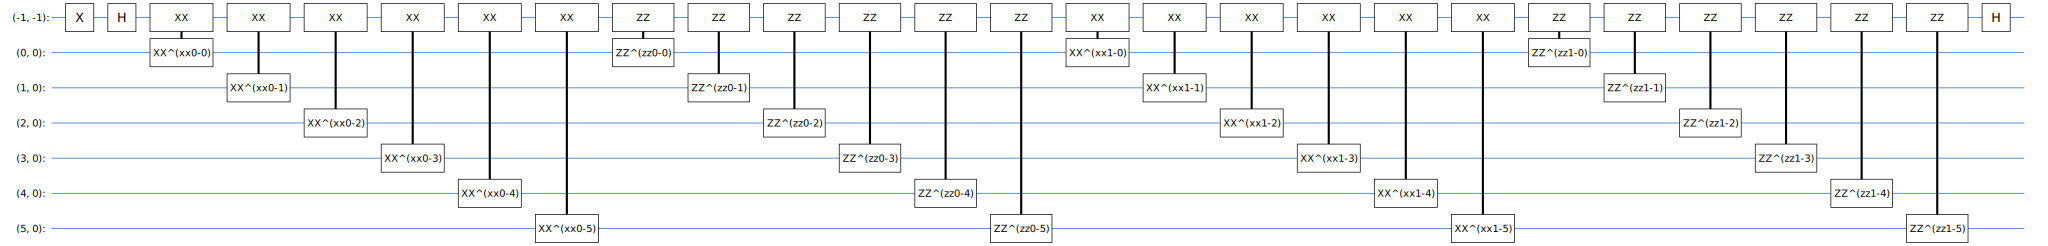

In [51]:
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [116]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [117]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [118]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [119]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=[hinge_accuracy])

In [120]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_6 (PQC)                  (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [121]:
EPOCHS = 10
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
# NUM_EXAMPLES = 1000

In [122]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [123]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 12049 samples, validate on 1968 samples
Epoch 1/10
12049/12049 [==============================] - 342s 28ms/sample - loss: 0.7304 - hinge_accuracy: 0.8497 - val_loss: 0.6969 - val_hinge_accuracy: 0.8558
Epoch 2/10
12049/12049 [==============================] - 343s 28ms/sample - loss: 0.6711 - hinge_accuracy: 0.8595 - val_loss: 0.6709 - val_hinge_accuracy: 0.8317
Epoch 3/10
12049/12049 [==============================] - 340s 28ms/sample - loss: 0.6565 - hinge_accuracy: 0.8435 - val_loss: 0.6726 - val_hinge_accuracy: 0.8311
Epoch 4/10
12049/12049 [==============================] - 342s 28ms/sample - loss: 0.6541 - hinge_accuracy: 0.8415 - val_loss: 0.6878 - val_hinge_accuracy: 0.8453
Epoch 5/10
12049/12049 [==============================] - 341s 28ms/sample - loss: 0.6576 - hinge_accuracy: 0.8440 - val_loss: 0.6714 - val_hinge_accuracy: 0.8337
Epoch 6/10
12049/12049 [==============================] - 340s 28ms/sample - loss: 0.6568 - hinge_accuracy: 0.8431 - val_loss: 0.6753 - 

KeyboardInterrupt: 

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

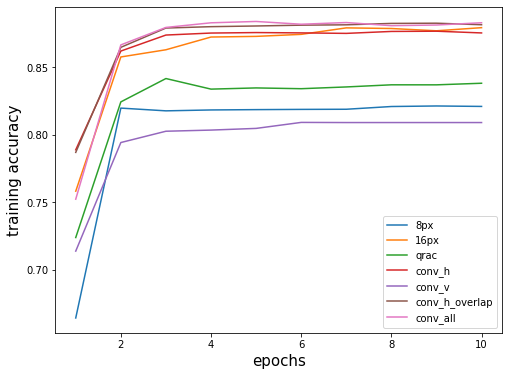

In [53]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444,555]
methods = ['8px', '16px', 'qrac', 'conv_h', 'conv_v', 'conv_h_overlap', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}*_10_{seed}_*')
#         print(files)
        if files == []:
            files = glob.glob(f'results/{method}*_10_1_{seed}_*')
        for file in files:
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in methods:
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['hinge_accuracy'])
#     print(val_coll)
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs', size=15)
plt.ylabel('training accuracy', size=15)
plt.legend()

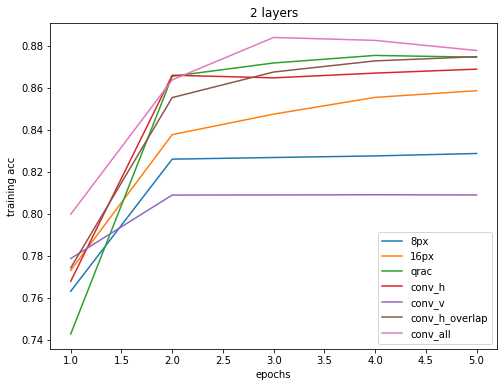

In [54]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444]
methods = ['8px', '16px', 'qrac', 'conv_h', 'conv_v', 'conv_h_overlap', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        for file in glob.glob(f'results/{method}*_2_{seed}_*'):
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in methods:
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['hinge_accuracy'])
    x_plot = np.arange(1,6)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs')
plt.ylabel('training acc')
plt.title('2 layers')
plt.legend()

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [32]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

Train on 12049 samples, validate on 1968 samples
1968/1968 [==============================] - 0s 106us/sample - loss: 0.0024 - accuracy: 0.9995


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [126]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(6,6,1)))
#     model.add(tf.keras.layers.Dense(3))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 37        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=40,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Train on 12049 samples, validate on 1968 samples
Epoch 1/40
12049/12049 - 1s - loss: 0.7612 - accuracy: 0.4262 - val_loss: 0.7156 - val_accuracy: 0.4619
Epoch 2/40
12049/12049 - 0s - loss: 0.6576 - accuracy: 0.5484 - val_loss: 0.6255 - val_accuracy: 0.5940
Epoch 3/40
12049/12049 - 0s - loss: 0.5767 - accuracy: 0.6553 - val_loss: 0.5540 - val_accuracy: 0.6768
Epoch 4/40
12049/12049 - 0s - loss: 0.5119 - accuracy: 0.7364 - val_loss: 0.4962 - val_accuracy: 0.7591
Epoch 5/40
12049/12049 - 0s - loss: 0.4596 - accuracy: 0.7962 - val_loss: 0.4490 - val_accuracy: 0.8105
Epoch 6/40
12049/12049 - 0s - loss: 0.4169 - accuracy: 0.8280 - val_loss: 0.4105 - val_accuracy: 0.8277
Epoch 7/40
12049/12049 - 0s - loss: 0.3818 - accuracy: 0.8526 - val_loss: 0.3786 - val_accuracy: 0.8430
Epoch 8/40
12049/12049 - 0s - loss: 0.3526 - accuracy: 0.8690 - val_loss: 0.3518 - val_accuracy: 0.8664
Epoch 9/40
12049/12049 - 0s - loss: 0.3280 - accuracy: 0.8904 - val_loss: 0.3291 - val_accuracy: 0.8770
Epoch 10/40
120

## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

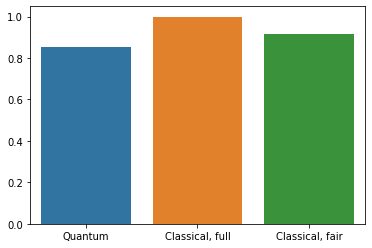

In [35]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])